<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Time-Forest" data-toc-modified-id="Time-Forest-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Time Forest</a></span></li><li><span><a href="#Optimize-Random-Forest-and-lgbm-benchmarks" data-toc-modified-id="Optimize-Random-Forest-and-lgbm-benchmarks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Optimize Random Forest and lgbm benchmarks</a></span><ul class="toc-item"><li><span><a href="#Tuned-RF" data-toc-modified-id="Tuned-RF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Tuned RF</a></span></li><li><span><a href="#lgbm" data-toc-modified-id="lgbm-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>lgbm</a></span></li></ul></li><li><span><a href="#Out-of-time" data-toc-modified-id="Out-of-time-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Out of time</a></span></li></ul></div>

# GE News - Time Forest Vs Sklearn's Random Forest and LightGBM

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pdb
import warnings
import seaborn as sns

from sklearn import metrics
from time import time
from sklearn.ensemble import RandomForestClassifier
#from time_robust_forest.models import TimeForestClassifier
from time_forest_estimator import TimeForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from models.aux_functions import *

warnings.filterwarnings('ignore')

/home/jovyan/.conda/envs/msc/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
STOP_WORDS = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']
CLUB_WORDS = ["verdão", "tricolor", "fla", "timão", "rubro", 
              "negro", "flamengo", "paulo", "palmeirense", "paulista", 
              "inter", "colorado", "internacional", "colorados", "colorada"]
STOP_WORDS += CLUB_WORDS
MAX_VOCABULARY = 300
positive_case = "flamengo"
PREFIX = "ge_paper"

In [5]:
data = pd.read_csv("~/Documents/datasets/ge_news/data/ge_news.csv", index_col=False)

In [6]:
data.shape

(139934, 6)

In [7]:
def create_different_time_slices(data, time_col="date", aggregation="weekly", n_months=None):
    if aggregation == "daily": return data[time_col].dt.date
    if aggregation == "weekly": return data[time_col].dt.week
    if aggregation == "monthly": return data[time_col].apply(lambda x: x.strftime("%Y-%m"))
    if aggregation == "semester": return False


def exclude_periods_without_positive_case(data, positive_case, period_column, threshold=20):
    df = data.groupby(period_column)["club"].apply(lambda x: np.sum(x == positive_case))
    df = df[df > threshold]
    return data[data[period_column].isin(df.index)]
    
def clean_club_name_from_article(data):
    data["text"] = data.apply(lambda x: x["text"].lower().replace(x["club"].replace("-", " "), ""), axis=1)
    return data

def exclude_numbers(data):
    data["text"] = data["text"].apply(lambda x: ''.join([i for i in x.lower() if not i.isdigit()]))
    return data

def drop_multiple_teams_news(data):
    multiple_team_news = data.groupby("link", as_index=False)["club"].count()
    multiple_team_news = multiple_team_news[multiple_team_news["club"] > 1]["link"]
    return data[~data["link"].isin(multiple_team_news)]


In [8]:
data = clean_club_name_from_article(data)
data = exclude_numbers(data)
data = drop_multiple_teams_news(data)

In [9]:
#data = data.sample(frac=0.1)

In [10]:
data.loc[:, "year"] = data["date"].apply(lambda x: x.split("/")[-1])
data.loc[:, "month"] = data["date"].apply(lambda x: x.split("/")[1])
data.loc[:, "date"] = pd.to_datetime(data["date"])

In [11]:
### Monthly context
data["year-month"] = data["year"] + "-" + data["month"]

### Weekly context
data["year-week"] = create_different_time_slices(data)
data["year-week"] = data["year"] + "-" + data["year-week"].astype(str)

In [12]:
data["target"] = data["club"].apply(lambda x: 1 if x == positive_case else 0)

print("The fraction of positive cases is {:.2f}".format(data["target"].mean()))

The fraction of positive cases is 0.09


In [13]:
data = exclude_periods_without_positive_case(data, positive_case, "year-month")

In [14]:
train_end_date = "2018-01"
holdout_end_date = "2020-12"
train_end_year = int(train_end_date.split("-")[0])

In [15]:
in_time = data[data["year-month"] < train_end_date]

train, test = train_test_split(in_time, 
                               test_size=0.2, 
                               random_state=42)

out_of_time = data[(data["year-month"] >= train_end_date) & (data["year-month"] <= holdout_end_date)]



In [16]:
target = "target"
time_column = "year-month"
time_column = "year"

In [17]:
print("Dataset shapes:")
print("Train: {}".format(train.shape))
print("Test: {}".format(test.shape))
print("Out of time: {}".format(out_of_time.shape))

Dataset shapes:
Train: (21062, 11)
Test: (5266, 11)
Out of time: (58376, 11)


In [18]:
vectorizer = TfidfVectorizer(max_features=MAX_VOCABULARY,
                             stop_words=STOP_WORDS,
                             binary=False,
                             use_idf=True,
                             norm=False)

train_vectors = pd.DataFrame(vectorizer.fit_transform(train["text"]).toarray(), columns=vectorizer.vocabulary_)
test_vectors = pd.DataFrame(vectorizer.transform(test["text"]).toarray(), columns=vectorizer.vocabulary_)
oot_vectors = pd.DataFrame(vectorizer.transform(out_of_time["text"]).toarray(), columns=vectorizer.vocabulary_)

In [19]:
train_vectors[time_column] = train[time_column].values
test_vectors[time_column] = test[time_column].values
oot_vectors[time_column] = out_of_time[time_column].values

In [20]:
model = RandomForestClassifier(max_depth=10, n_estimators=25)

In [21]:
model.fit(train_vectors.drop(columns=["year"]), train["target"].values)

RandomForestClassifier(max_depth=10, n_estimators=25)

In [22]:
train["prediction"] = model.predict_proba(train_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(train[target], train["prediction"])

0.9365487640416333

In [23]:
test["prediction"] = model.predict_proba(test_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(test[target], test["prediction"])

0.881432357632048

In [24]:
out_of_time["prediction"] = model.predict_proba(oot_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(out_of_time[target], out_of_time["prediction"])

0.7841751229487728

## Optimize Random Forest and lgbm benchmarks

In [25]:
from pycaret.classification import *

In [26]:
train_features = pd.DataFrame(train_vectors)
oot_features = pd.DataFrame(oot_vectors)

In [27]:
features = [col for col in train_features.columns if col != time_column]

In [28]:
holdout_data_opt = oot_features.copy(deep=True)
holdout_data_opt[target] = out_of_time[target].values

In [29]:
test_data_opt = pd.DataFrame(test_vectors).copy(deep=True)
test_data_opt[target] = test[target].values

In [30]:
train_data_opt = train_features.copy(deep=True)
train_data_opt[target] = train[target].values

In [31]:
train_data_opt.shape

(21062, 302)

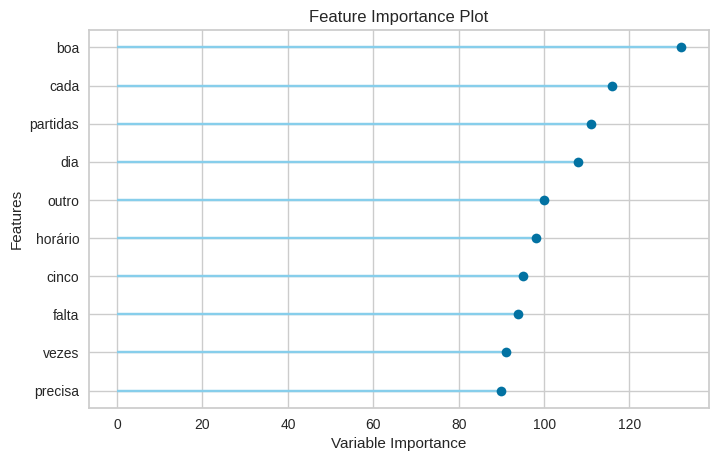

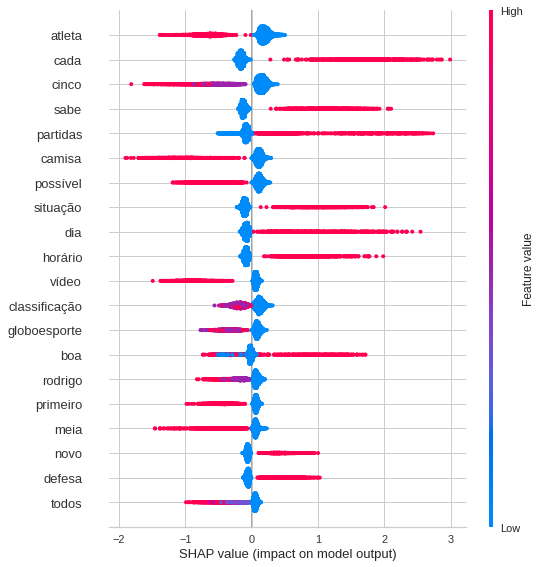

LGBMClassifier(bagging_fraction=1.0, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=16, min_child_weight=0.001, min_split_gain=0,
               n_estimators=140, n_jobs=-1, num_leaves=80, objective=None,
               random_state=1495, reg_alpha=0.1, reg_lambda=5, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [32]:
clf1 = setup(train_data_opt[features + [target]],
             target="target",
             log_experiment=False, 
             experiment_name="ge_exp",
             silent=True)

#best_model = compare_models()

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

lgbm = create_model("lightgbm")

tuned_lgbm = tune_model(lgbm,
                        fold=5,
                        n_iter=50,
                        optimize="AUC")

plot_model(tuned_lgbm, plot="feature")
interpret_model(tuned_lgbm)

best = automl(optimize='AUC')
best

### Tuned RF

In [33]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=290, n_jobs=-1, oob_score=False,
                       random_state=1495, verbose=0, warm_start=False)

In [34]:
benchmark = tuned_rf

In [35]:
benchmark.fit(train_vectors.drop(columns=["year"]), train["target"].values)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=290, n_jobs=-1, oob_score=False,
                       random_state=1495, verbose=0, warm_start=False)

In [ ]:
interpret_model(benchmark)

In [ ]:
train["prediction_rf"] = benchmark.predict_proba(train_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(train[target], train["prediction_rf"])

In [ ]:
test["prediction_rf"] = benchmark.predict_proba(test_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(test[target], test["prediction_rf"])

In [ ]:
out_of_time["prediction_rf"] = benchmark.predict_proba(oot_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(out_of_time[target], out_of_time["prediction_rf"])

### lgbm

In [ ]:
tuned_lgbm

In [ ]:
benchmark = tuned_lgbm
benchmark.fit(train_vectors.drop(columns=["year"]), train["target"].values)
train["prediction_lgbm"] = benchmark.predict_proba(train_vectors.drop(columns=["year"]))[:, 1]
print(roc_auc_score(train[target], train["prediction_lgbm"]))

test["prediction_lgbm"] = benchmark.predict_proba(test_vectors.drop(columns=["year"]))[:, 1]
print(roc_auc_score(test[target], test["prediction_lgbm"]))

out_of_time["prediction_lgbm"] = benchmark.predict_proba(oot_vectors.drop(columns=["year"]))[:, 1]
print(roc_auc_score(out_of_time[target], out_of_time["prediction_lgbm"]))

### Feature Importance

In [ ]:
train_ = train_data_opt
test_ = test_data_opt
out_of_time_ = holdout_data_opt

In [ ]:
results = reverse_learning_curve(train_, out_of_time_, tuned_rf, features, target, time_column, roc_auc_score, n_rounds=5)

In [ ]:
benchmark_importances = results["feature_importance"][-1].copy(deep=True)
benchmark_importances.rename("RF", inplace=True)
benchmark_importances.sort_values(ascending=False)

In [ ]:
set_style()

In [ ]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()


## Time Forest

In [ ]:
CHALLENGER_N_ESTIMATORS = 60
CHALLENGER_MAX_DEPTH = 10

In [ ]:
time_model = TimeForestClassifier(n_estimators=CHALLENGER_N_ESTIMATORS, 
                                  time_column=time_column, 
                                  max_depth=CHALLENGER_MAX_DEPTH,
                                  min_sample_periods=10,
                                  max_features=1.0,
                                  n_jobs=-1,
                                  #criterion="std",
                                  multi=True)

time_model.fit(train_vectors, train["target"].values)

train["time_prediction"] = time_model.predict_proba_(train_vectors)


test["time_prediction"] = time_model.predict_proba_(test_vectors)


out_of_time["time_prediction"] = time_model.predict_proba_(oot_vectors)


In [ ]:
print(roc_auc_score(train[target], train["time_prediction"]))
print(roc_auc_score(test[target], test["time_prediction"]))
print(roc_auc_score(out_of_time[target], out_of_time["time_prediction"]))

``` 
0.8781779388485127
0.8517589093053489
0.8113647171923846
```

In [ ]:
time_model.feature_importance[:20]

In [ ]:
challenger_model = TimeForestClassifier(n_estimators=CHALLENGER_N_ESTIMATORS, 
                                  time_column=time_column, 
                                  max_depth=CHALLENGER_MAX_DEPTH,
                                  min_sample_periods=10,
                                  max_features=1.0,
                                  n_jobs=-1,
                                  #criterion="std",
                                  multi=True)

In [ ]:
results_trt = reverse_learning_curve(train_, out_of_time_, challenger_model, features, target, time_column, roc_auc_score, n_rounds=5, trt_model=True)

In [ ]:
challenger_model_importances = results_trt["feature_importance"][-1].copy(deep=True)
challenger_model_importances.rename("TRF", inplace=True)

In [ ]:
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)


all_models_importance.fillna(0, inplace=True)
all_models_importance

In [ ]:
all_models_importance["TRF"].sort_values(ascending=False)[:30]

In [ ]:
all_models_importance["RF"].sort_values(ascending=False)[:30]

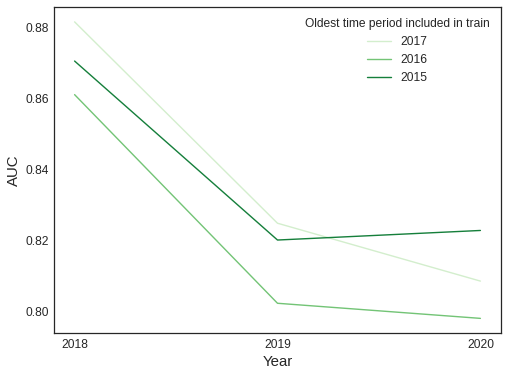

In [100]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

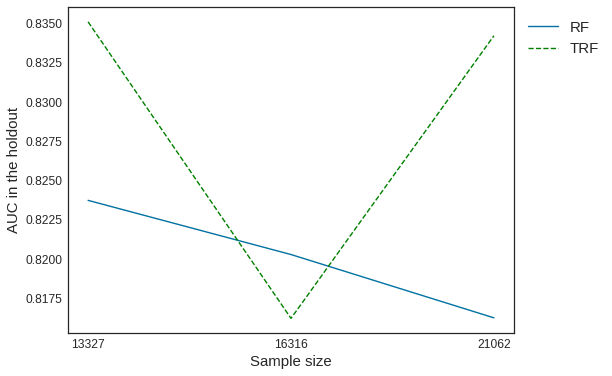

In [101]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

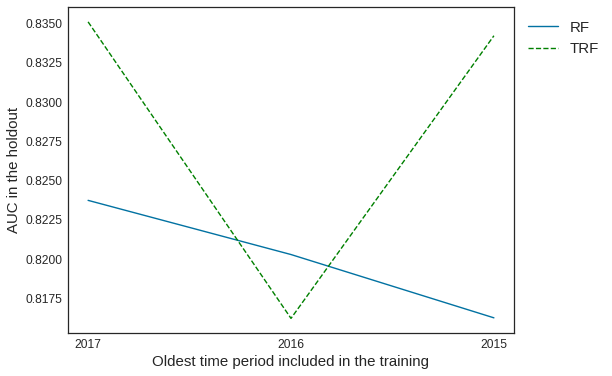

In [102]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()


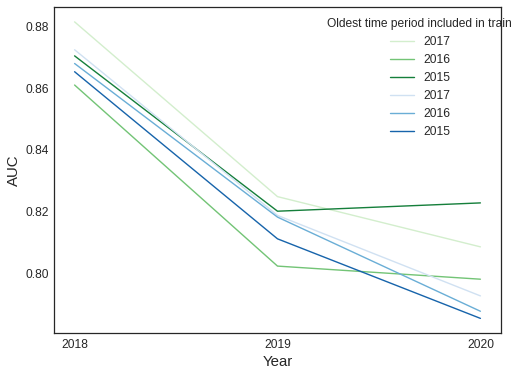

In [103]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance Comparison

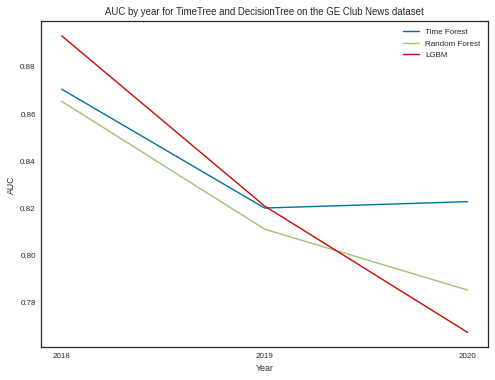

In [104]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Forest")
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Random Forest")
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

plt.legend()
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

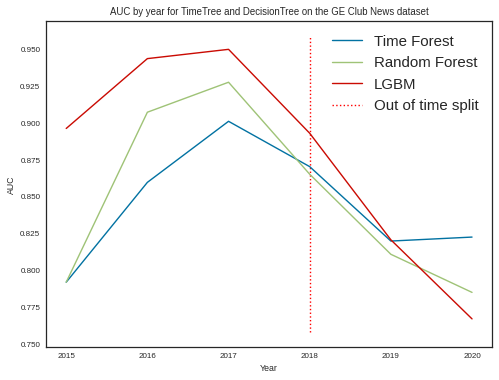

In [105]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")
plt.legend(bbox_to_anchor=(1.00, 1.0), fontsize=15)
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

In [ ]:

fig, ax = plt.subplots()

pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Robust Forest",
                                                                                                                        color="green", linestyle="dashed")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Random Forest", 
                                                                                                                       linestyle="-.")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM", color="orange")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))

#plt.legend(bbox_to_anchor=(1.05, 1.0))
#plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")

plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
#plt.savefig("images/ge_sklearn.eps", format="eps", bbox_inches="tight")
plt.savefig("../images/{}_sklearn_binary_large.eps".format(PREFIX), format="eps")
plt.show()

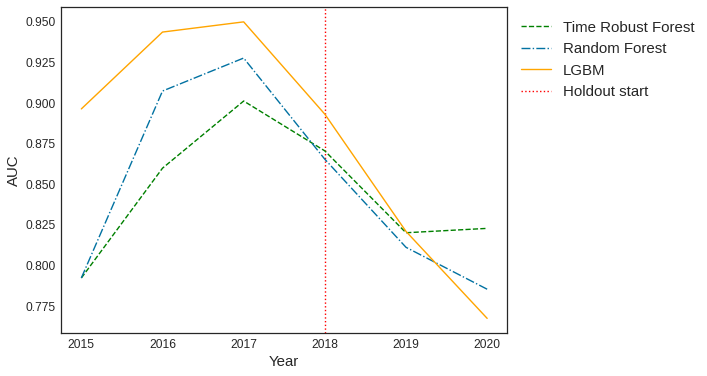

In [106]:
fig, ax = plt.subplots()

pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Robust Forest",
                                                                                                                        color="green", linestyle="dashed")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Random Forest", 
                                                                                                                       linestyle="-.")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM", color="orange")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))

#plt.legend(bbox_to_anchor=(1.05, 1.0))
#plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")

plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
#plt.savefig("images/ge_sklearn.eps", format="eps", bbox_inches="tight")
plt.savefig("../images/{}_sklearn_binary.eps".format(PREFIX), format="eps")
plt.show()

In [ ]:
fig, ax = plt.subplots()

pd.concat([test, out_of_time]).groupby("year-month").apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).rolling(3).mean().plot(label="Time Robust Forest",
                                                                                                                        color="green", linestyle="dashed")
pd.concat([test, out_of_time]).groupby("year-month").apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).rolling(3).mean().plot(label="Random Forest", 
                                                                                                                       linestyle="-.")
pd.concat([test, out_of_time]).groupby("year-month").apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).rolling(3).mean().plot(label="LGBM", color="orange")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.vlines(train["year-month"].nunique(), ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))

#plt.legend(bbox_to_anchor=(1.05, 1.0))
#plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")

plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
#plt.savefig("images/ge_sklearn.eps", format="eps", bbox_inches="tight")
plt.savefig("../images/{}_sklearn_binary_ym.eps".format(PREFIX), format="eps")
plt.show()

## Minimum samples by period effect

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)

In [ ]:
min_sample_knob = {}

In [ ]:
min_sample_periods_values = [1, 5, 10, 50, 250, 500, 1000]

In [ ]:
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=time_column,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=min_sample_periods,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        max_features=1.0,    
                                        multi=True)
    
    model_split_time.fit(train_[features + [time_column]], train_[target])
    out_of_time_["time_split_prediction"] = model_split_time.predict_proba(out_of_time_[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time_[target], out_of_time_["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time_.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train_["time_split_prediction"] = model_split_time.predict(train_[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train_[target], train_["time_split_prediction"]))
    
    test_["time_split_prediction"] = model_split_time.predict(test_[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test_[target], test_["time_split_prediction"]))

In [ ]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

In [ ]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[time_column].unique())
#plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

training_segments = train[time_column].nunique()
for min_sample_periods in min_sample_periods_values:

    model = tuned_rf
    model.set_params(min_samples_leaf=training_segments * min_sample_periods)
    
    
    model.fit(train_[features],
              train_[target])
     
    out_of_time_["time_split_prediction"] = model.predict_proba(out_of_time_[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time_[target], out_of_time_["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time_.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train_["time_split_prediction"] = model.predict(train_[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train_[target], train_["time_split_prediction"]))
    
    test_["time_split_prediction"] = model.predict(test_[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test_[target], test_["time_split_prediction"]))

In [ ]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[time_column].unique())
#plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()



In [ ]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[time_column].unique())
#plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=13)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

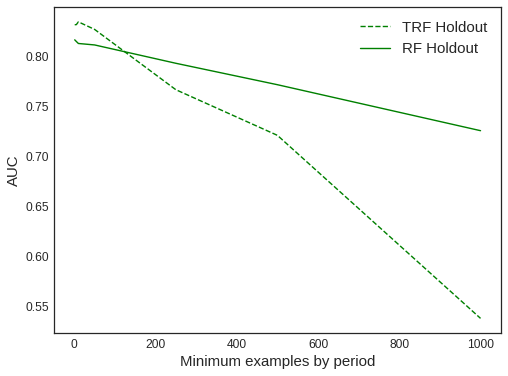

In [88]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain Classifier

In [ ]:
train_["domain"] = 1
test_["domain"] = 1
out_of_time_["domain"] = 0


In [ ]:
domain_data = pd.concat([train_, test_, out_of_time_])

In [ ]:
domain_data.shape

In [ ]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [ ]:
train_domain.shape

In [ ]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

In [ ]:
domain_model = tuned_domain_rf

In [ ]:
domain_model.fit(train_domain[features], train_domain["domain"])

In [ ]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [ ]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

## Other optiomization design for the RF

In [ ]:
last_time_segment_in_train = np.max(in_time[time_column].unique())
last_time_segment_in_train

In [ ]:
posfix = str(last_time_segment_in_train)

In [ ]:
in_time = pd.concat([train_, test_])

In [ ]:
new_train = in_time[in_time[time_column] < last_time_segment_in_train]
new_validation = in_time[in_time[time_column] == last_time_segment_in_train]

In [ ]:
clf1 = setup(new_train[features + [target]], target=target,
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                      optimize="AUC",
                      n_iter=25)

In [ ]:
tuned_rf

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train_[features], train_[target])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train_[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test_[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time_[features])[:, 1]

In [ ]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [ ]:
clf1 = setup(new_train[features + [target]], target=target,
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train_[features], train_[target])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train_[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test_[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time_[features])[:, 1]

In [ ]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
1

In [ ]:
1